# Задание взято с [платформы](https://karpov.courses/)
## Задачи.
Представьте, что вы устроились работать аналитиком в отдел рекламы, и ваша первая задача — помочь коллегам разобраться с некоторыми вопросами:

1. Получить статистику по дням. Посчитать число всех событий по дням, число показов, число кликов, число уникальных объявлений и уникальных кампаний.
2. Разобраться, почему случился такой скачок 2019-04-05? Каких событий стало больше? У всех объявлений или только у некоторых?
3. Найти топ 10 объявлений по CTR за все время. CTR — это отношение всех кликов объявлений к просмотрам. Например, если у объявления было 100 показов и 2 клика, CTR = 0.02. Различается ли средний и медианный CTR объявлений в наших данных?
4. Похоже, в наших логах есть баг, объявления приходят с кликами, но без показов! Сколько таких объявлений, есть ли какие-то закономерности? Эта проблема наблюдается на всех платформах?
5. Есть ли различия в CTR у объявлений с видео и без? А чему равняется 95 процентиль CTR по всем объявлениям за 2019-04-04?
6. Для финансового отчета нужно рассчитать наш заработок по дням. В какой день мы заработали больше всего? В какой меньше? Мы списываем с клиентов деньги, если произошел клик по CPC объявлению, и мы списываем деньги за каждый показ CPM объявления, если у CPM объявления цена 200 рублей, то за один показ мы зарабатываем 200 / 1000.
7. Какая платформа самая популярная для размещения рекламных объявлений? Сколько процентов показов приходится на каждую из платформ (колонка platform)?
8. А есть ли такие объявления, по которым сначала произошел клик, а только потом показ?
   
## Описание колонок
- date — день, в который происходят события
- time — точное время события
- event — тип события, может быть или показ или клик по рекламе
- platform — платформа, на которой произошло рекламное событие
- ad_id — id рекламного объявления
- client_union_id — id рекламного клиента
- campaign_union_id — id рекламной кампании
- ad_cost_type — тип объявления с оплатой за клики (CPC) или за показы (CPM)
- ad_cost — стоимость объявления в рублях, для CPC объявлений — это цена за клик, для CPM — цена за 1000 показов
- has_video — есть ли у рекламного объявления видео
- target_audience_count — размер аудитории, на которую таргетируется объявление

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
ads_data = pd.read_csv('lesson_5_ads_data.csv.zip', compression='zip')

In [3]:
ads_data['date'] = pd.to_datetime(ads_data['date'])

In [4]:
ads_data['full_date'] = pd.to_datetime(ads_data['time'], unit='s')

In [5]:
ads_data.head()

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id,full_date
0,23456,1554076848,view,2019-04-01,CPM,0,5681,23456,android,190.0,125560,793,2019-04-01 00:00:48
1,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,1041,2019-04-01 16:24:26
2,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,41,2019-04-01 16:24:26
3,42987,1554135866,view,2019-04-01,CPM,0,28541,42985,ios,199.1,80160,898,2019-04-01 16:24:26
4,23456,1554135866,view,2019-04-01,CPM,0,5681,23456,web,190.0,125560,29,2019-04-01 16:24:26


In [6]:
ads_data.shape

(3176714, 13)

In [7]:
ads_data.dtypes

ad_id                             int64
time                              int64
event                            object
date                     datetime64[ns]
ad_cost_type                     object
has_video                         int64
client_union_id                   int64
campaign_union_id                 int64
platform                         object
ad_cost                         float64
target_audience_count             int64
user_id                           int64
full_date                datetime64[ns]
dtype: object

- Получить статистику по дням. Посчитать число всех событий по дням, число показов, число кликов, число уникальных объявлений и уникальных кампаний.

- Разобраться, почему случился такой скачок `2019-04-05`? Каких событий стало больше? У всех объявлений или только у некоторых?

In [8]:
ads_data.groupby('date', as_index=False) \
        .aggregate({'event': 'count'}) \
        .style.highlight_max('event', color='red')
        

,date,event
0,2019-04-01 00:00:00,35567
1,2019-04-02 00:00:00,147329
2,2019-04-03 00:00:00,216529
3,2019-04-04 00:00:00,127699
4,2019-04-05 00:00:00,2284883
5,2019-04-06 00:00:00,364707


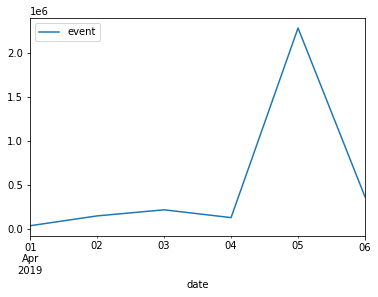

In [9]:
# удобно будет построить график и увидеть скачок (как в уроке)

ads_data.groupby('date') \
        .aggregate({'event': 'count'}) \
        .plot()

# на графике отчетливо видно как сильно изменилось

In [10]:
ads_data.groupby(['date', 'event']) \
        .aggregate({'ad_id': 'count'}) \
        .rename(columns={'ad_id': 'event_count'}) \
        .unstack(level='event') \
        .style.background_gradient(subset=[('event_count', 'click')], cmap='Reds') \
        .background_gradient(subset=[('event_count', 'view')], cmap='Blues')


In [11]:
# Удобно также сделать через pivot_table 
ads_data.groupby(['date', 'event'], as_index=False) \
    .agg({'ad_id': 'count'}) \
    .pivot(index='date', columns='event', values='ad_id').reset_index() \
    .style.background_gradient(subset='click', cmap='Reds') \
    .background_gradient(subset='view', cmap='Blues')

# И тогда избавляемся от мультииндексов засчет reset_index()

event,date,click,view
0,2019-04-01 00:00:00,735,34832
1,2019-04-02 00:00:00,1518,145811
2,2019-04-03 00:00:00,1678,214851
3,2019-04-04 00:00:00,1517,126182
4,2019-04-05 00:00:00,501595,1783288
5,2019-04-06 00:00:00,80420,284287


In [12]:
ads_data.groupby(['date', 'ad_id']) \
        .aggregate({'time': 'count'}) \
        .rename(columns={'time': 'ad_count'}) \
        .sort_values('ad_count', ascending=False)

ad_count
date       ad_id           
2019-04-05 112583   2166611
2019-04-06 112583    348613
2019-04-03 104798     94554
2019-04-05 29927      27186
2019-04-03 102587     18893
...                     ...
2019-04-02 25665          3
           113348         3
           46363          2
2019-04-01 41424          2
2019-04-02 120444         1

[716 rows x 1 columns]

In [13]:
ads_data.groupby(['date', 'campaign_union_id']) \
        .aggregate({'time': 'count'}) \
        .rename(columns={'time': 'campaign_count'}) \
        .sort_values('campaign_count', ascending=False)

campaign_count
date       campaign_union_id                
2019-04-05 112260                    2166611
2019-04-06 112260                     348613
2019-04-03 104798                      94554
2019-04-05 29901                       27186
2019-04-03 102535                      18893
...                                      ...
2019-04-02 113192                          3
           25663                           3
2019-04-01 41424                           2
2019-04-02 46363                           2
           120440                          1

[709 rows x 1 columns]

In [14]:
'''здесь видно сразу, что около 90% всех показов занимает одно объявление, 
но также можно посмотреть разбивку объявления по дню конкретному''' 

ads_data[ads_data.date == '2019-04-05'] \
    .groupby('ad_id') \
    .agg({'time': 'count'}) \
    .sort_values('time', ascending=False)

,time
ad_id,
112583,2166611
29927,27186
44635,8268
46583,7327
44956,5656
...,...
46433,17
21405,16
46024,16


In [15]:
ad_id = 112583

Видим скачок у компании с id `112260` 5 и 6 апреля и аналогично у объявления с id `112583`

In [16]:
# можно также посмотреть сколько вообще объявление висит, может, оно аномально появилось и исчезло
ads_data.query('ad_id == @ad_id') \
        .groupby('date') \
        .agg({'time': 'count'})

,time
date,
2019-04-05,2166611
2019-04-06,348613


Найти топ 10 объявлений по CTR за все время. CTR — это отношение всех кликов объявлений к просмотрам. Например, если у объявления было 100 показов и 2 клика, CTR = 0.02. Различается ли средний и медианный CTR объявлений в наших данных?

In [17]:
ads_data_by_ad = ads_data.groupby(['ad_id', 'event'], as_index=False) \
    .agg({'time': 'count'}) \
    .pivot_table(index='ad_id', columns='event', values='time').reset_index()

In [18]:
ads_data_by_ad = ads_data_by_ad.assign(ctr = ads_data_by_ad.click / ads_data_by_ad.view, 
                           ctr_per = 100 * ads_data_by_ad.click / ads_data_by_ad.view)

In [19]:
ads_data_by_ad.ctr.mean()

0.020628096080757954

In [20]:
ads_data_by_ad.ctr.median()

0.010753240746688594

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


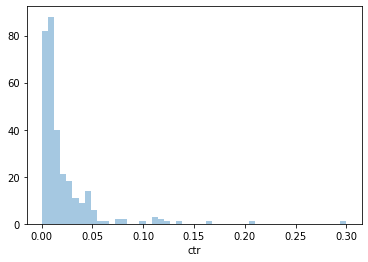

In [21]:
sns.distplot(ads_data_by_ad.ctr, kde=False)

Похоже, в наших логах есть баг, объявления приходят с кликами, но без показов! Сколько таких объявлений, есть ли какие-то закономерности? Эта проблема наблюдается на всех платформах?

In [22]:
ads_data_by_ad = ads_data_by_ad.fillna(0)

In [23]:
ads_ids_bug = ads_data_by_ad.query('view == 0').ad_id

In [24]:
ads_data[ads_data.ad_id.isin(ads_ids_bug)] \
    .groupby('platform', as_index=False) \
    .agg({'ad_id': 'count'}) \
    .sort_values('ad_id')

,platform,ad_id
2,web,53
1,ios,92
0,android,141


In [25]:
ads_data \
    .groupby('platform', as_index=False) \
    .agg({'ad_id': 'count'}) \
    .sort_values('ad_id')

,platform,ad_id
2,web,635425
1,ios,953078
0,android,1588211


Есть ли различия в CTR у объявлений с видео и без? А чему равняется 95 процентиль CTR по всем объявлениям за `2019-04-04`?

In [26]:
# CTR без видео
len(ads_data.query('(has_video == 0) & (event == "click")')) / len(ads_data.query('(has_video == 0) & (event == "view")'))

0.22750243695763897

In [27]:
# CTR с видео
len(ads_data.query('(has_video == 1) & (event == "click")')) / len(ads_data.query('(has_video == 1) & (event == "view")'))

0.0036424768842813113

In [28]:
# Как будто различия имеются...

In [29]:
df_04_04 = ads_data[ads_data.date == '2019-04-04'].groupby(['ad_id', 'event'], as_index=False) \
    .agg({'time': 'count'}) \
    .pivot_table(index='ad_id', columns='event', values='time').reset_index() \
    .fillna(0)

In [30]:
df_04_04 = df_04_04.assign(ctr = df_04_04.click / df_04_04.view)

df_04_04

event,ad_id,click,view,ctr
0,9071,3.0,352.0,0.008523
1,9776,37.0,1115.0,0.033184
2,10601,3.0,848.0,0.003538
3,11887,151.0,8720.0,0.017317
4,12137,1.0,170.0,0.005882
...,...,...,...,...
145,120790,0.0,19.0,0.000000
146,121779,68.0,1116.0,0.060932
147,121790,7.0,701.0,0.009986
148,121941,0.0,95.0,0.000000


In [31]:
df_04_04[df_04_04.ctr > 0].ctr.quantile(0.95)

0.10211538461538454

Для финансового отчета нужно рассчитать наш заработок по дням. В какой день мы заработали больше всего? В какой меньше? Мы списываем с клиентов деньги, если произошел клик по CPC объявлению, и мы списываем деньги за каждый показ CPM объявления, если у CPM объявления цена 200 рублей, то за один показ мы зарабатываем 200 / 1000.

In [32]:
CPM_data_cost = ads_data[(ads_data.ad_cost_type == 'CPM') & (ads_data.event == 'view')].groupby('date') \
    .ad_cost.sum() / 1000
CPC_data_cost = ads_data[(ads_data.ad_cost_type == 'CPC') & (ads_data.event == 'click')].groupby('date') \
    .ad_cost.sum() 

In [33]:
CPM_data_cost = pd.DataFrame(CPM_data_cost).rename(columns={'ad_cost': 'CPM_cost'}).reset_index()
CPC_data_cost = pd.DataFrame(CPC_data_cost).rename(columns={'ad_cost': 'CPC_cost'}).reset_index()

In [34]:
data_cost = CPM_data_cost.merge(CPC_data_cost, on='date')
data_cost['total_cost'] = data_cost['CPM_cost'] + data_cost['CPC_cost']

data_cost.style.highlight_max(subset='total_cost', color='lightgreen') \
    .highlight_max(subset='CPM_cost', color='pink')

,date,CPM_cost,CPC_cost,total_cost
0,2019-04-01 00:00:00,6122.812300,7036.900000,13159.712300
1,2019-04-02 00:00:00,26173.305100,7663.700000,33837.005100
2,2019-04-03 00:00:00,34612.317000,38597.200000,73209.517000
3,2019-04-04 00:00:00,19416.356800,26878.000000,46294.356800
4,2019-04-05 00:00:00,354178.548996,4381.200000,358559.748996
5,2019-04-06 00:00:00,56587.337600,253.000000,56840.337600


Какая платформа самая популярная для размещения рекламных объявлений? Сколько процентов показов приходится на каждую из платформ (колонка platform)?

In [35]:
# Самая популярная платформа уже затрагивалась выше 

ads_data \
    .groupby('platform', as_index=False) \
    .agg({'ad_id': 'count'}) \
    .sort_values('ad_id')

,platform,ad_id
2,web,635425
1,ios,953078
0,android,1588211


In [36]:
ads_data_platform = ads_data \
    .groupby(['platform', 'event'], as_index=False) \
    .agg({'ad_id':'count'}) \
    .pivot(index='platform', columns='event', values='ad_id').reset_index()

In [37]:
ads_data_platform.assign(click_per=ads_data_platform.view/ads_data_platform.view.sum()*100,
                        view_per=ads_data_platform.click/ads_data_platform.click.sum()*100)

event,platform,click,view,click_per,view_per
0,android,293022,1295189,50.021763,49.879226
1,ios,176964,776114,29.974460,30.123429
2,web,117477,517948,20.003777,19.997345


А есть ли такие объявления, по которым сначала произошел клик, а только потом показ?

In [38]:
ads_data.groupby(['ad_id', 'event'], as_index=False) \
    .agg({'time': 'min'}) \
    .pivot(index='ad_id', columns='event', values='time').reset_index() \
    .query('click < view')

event,ad_id,click,view
27,16548,1.554336e+09,1.554336e+09
81,30939,1.554165e+09,1.554173e+09
138,40464,1.554164e+09,1.554164e+09
158,42007,1.554423e+09,1.554423e+09
185,44543,1.554336e+09,1.554337e+09
201,45436,1.554336e+09,1.554336e+09
324,119450,1.554336e+09,1.554336e+09
